# Linear Models
## Dream Team - ORIE 4741 Project

In [1]:
using CSV, Plots, DataFrames, Statistics, LinearAlgebra, GLM, Random, Lasso, MLBase
# LassoPlot is not working with the other updated packages

In [2]:
include("../plot_pred.jl")

plot_pred_true (generic function with 2 methods)

Load data from CSV.

In [6]:
df = CSV.read("../data collection/weekly_ff_elo_impute.csv", missingstring = "NA", DataFrame)
# df = DataFrame(load("weekly_ff.csv"))

feature_names = names(df)
for i in 1:58
    println(string(i), "\t", string(feature_names[i]), "\t\t\t", string(eltype(df[!, i])))
end

1	week			Int64
2	Player			String
3	Pos			String
4	team1			String
5	PassingYds			Union{Missing, Int64}
6	PassingTD			Union{Missing, Int64}
7	Int			Union{Missing, Int64}
8	PassingAtt			Union{Missing, Int64}
9	Cmp			Union{Missing, Int64}
10	RushingAtt			Union{Missing, Int64}
11	RushingYds			Union{Missing, Int64}
12	RushingTD			Union{Missing, Int64}
13	Rec			Union{Missing, Int64}
14	Tgt			Union{Missing, Int64}
15	ReceivingYds			Union{Missing, Int64}
16	ReceivingTD			Union{Missing, Int64}
17	FL			Union{Missing, Int64}
18	PPRFantasyPoints			Union{Missing, Float64}
19	StandardFantasyPoints			Union{Missing, Float64}
20	HalfPPRFantasyPoints			Union{Missing, Float64}
21	type			String
22	game_id			Int64
23	team2			String
24	season			Int64
25	team1_score			Int64
26	team2_score			Int64
27	PassingYds_cum			Float64
28	PassingTD_cum			Float64
29	Int_cum			Float64
30	PassingAtt_cum			Float64
31	Cmp_cum			Float64
32	RushingAtt_cum			Float64
33	RushingYds_cum			Float64
34	RushingTD_cum			Float64
35	Rec_c

Train/test split with proportion of training data = 0.8

In [26]:
Random.seed!(0)

df = df[.!(ismissing.(df[!, :StandardFantasyPoints])), :]
df = df[shuffle(1:end), :]

train_proportion = 0.8
n = size(df, 1)
println("Size of dataset: ", string(n))

ntrain = convert(Int, round(train_proportion*n))

target = df[:, [:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints]]

train_x = df[1:ntrain, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
test_x = df[ntrain:end, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]

train_std = replace(target[1:ntrain, :StandardFantasyPoints], missing=>0)
test_std = replace(target[ntrain:end, :StandardFantasyPoints], missing=>0)

train_ppr = replace(target[1:ntrain, :PPRFantasyPoints], missing=>0)
test_ppr = replace(target[ntrain:end, :PPRFantasyPoints], missing=>0)

train_half = replace(target[1:ntrain, :HalfPPRFantasyPoints], missing=>0)
test_half = replace(target[ntrain:end, :HalfPPRFantasyPoints], missing=>0)

# let's take a look
train_x

Size of dataset: 51588


,week,Player,Pos,team1,PassingYds,PassingTD,Int,PassingAtt
,Int64,String,String,String,Int64?,Int64?,Int64?,Int64?
1,15,Thomas Jones,RB,KAN,0,0,0,0
2,4,Chris Ivory,RB,NYJ,0,0,0,0
3,13,Pierre Garcon,WR,WAS,0,0,0,0
4,5,Toby Gerhart,RB,MIN,0,0,0,0
5,10,Brian Hoyer,QB,CLE,198,0,0,23
6,9,Ben Watson,TE,CLE,0,0,0,0
7,17,DeAndre Hopkins,WR,HOU,0,0,0,0
8,17,Elijhaa Penny,RB,NYG,0,0,0,0
9,12,Willie Snead,WR,NOR,50,1,0,1


Create a real-valued subset.

In [27]:
labels_real = [
    :PassingYds_cum,
    :PassingTD_cum,
    :Int_cum,
    :PassingAtt_cum,
    :Cmp_cum,
    :RushingAtt_cum,
    :RushingYds_cum,
    :RushingTD_cum,
    :Rec_cum,
    :Tgt_cum,
    :ReceivingYds_cum,
    :ReceivingTD_cum,
    :FL_cum,
    :team1_score_cum,
    :team2_score_cum,
    :PassingYds_prev,
    :PassingTD_prev,
    :Int_prev,
    :PassingAtt_prev,
    :Cmp_prev,
    :RushingAtt_prev,
    :RushingYds_prev,
    :RushingTD_prev,
    :Rec_prev,
    :Tgt_prev,
    :ReceivingYds_prev,
    :ReceivingTD_prev,
    :FL_prev,
    :team1_score_prev,
    :team2_score_prev,
    :elo1_pre,
    :elo2_pre
]

train_real = train_x[:, labels_real]
test_real = test_x[:, labels_real];

Convert the categorical labels into one-hot encoded data. This is for the team of the player (team1) and the team of the opponent (team2) as well as the position. 

In [28]:
cat_labels = [
  # :team1,
  # :team2,
  :Pos
]

#Sets of all categories in a particular column
cats_sets = [unique(df[:, label]) for label in cat_labels]

"Computes a onehot vector for every entry in column given a set of categories cats"
function onehot(column, cats=unique(column))
    len = length(column)
    len_val = length(cats)
    result = zeros(len, len_val)
    
    for i=1:len
        string=column[i]
        for j=1:len_val
            if contains(string, cats[j])
                result[i,j]=1
            end
        end
    end
    result
end

# [onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]

train_cat_vals = hcat([onehot(train_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);
test_cat_vals = hcat([onehot(test_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...);

In [29]:
# Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals, ones(nrow(train_x))), NaN=>0);
Xtrain = replace(hcat(convert(Matrix, train_real), train_cat_vals), missing=>0);
# Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals, ones(nrow(test_x))), NaN=>0);
Xtest = replace(hcat(convert(Matrix, test_real), test_cat_vals), missing=>0);

In [71]:
# export 
train_df = DataFrame(hcat(Xtrain, train_std, train_ppr, train_half));
test_df = DataFrame(hcat(Xtest, test_std, test_ppr, test_half));
# CSV.write("$(pwd())\\train_impute.csv", train_df);
# CSV.write("$(pwd())\\test_impute.csv", test_df)

"C:\\Users\\darre\\Documents\\_cornell 20-21\\orie 4741\\dream-team\\base models\\test_impute.csv"

In [72]:
train_df

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,8.61538,25.9231,0.0,0.307692
2,0.0,0.0,0.0,0.0,0.0,17.0,74.0,1.0,1.5
3,0.0,0.0,0.0,0.0,0.0,0.2,1.4,0.0,3.0
4,0.0,0.0,0.0,0.0,0.0,3.5,11.0,0.0,0.5
5,251.75,1.25,0.5,31.5,18.25,1.375,0.375,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.28571
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.73333
8,0.0,0.0,0.0,0.0,0.0,1.0,3.57143,0.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.11111


In [32]:
"""This function computes the mean squared error."""
function MSE(y, pred)
    error = (y.-pred).^2
    mse = sum(error[:, 1])/size(error, 1)
    return mse
end

MSE

# OLS
## OLS by hand

In [33]:
w = Xtrain \ train_std
train_pred = sum(w'.*Xtrain, dims = 2)
test_pred = sum(w'.*Xtest, dims = 2)

train_MSE = MSE(train_std, train_pred)
test_MSE = MSE(test_std, test_pred)

32.58896789315857

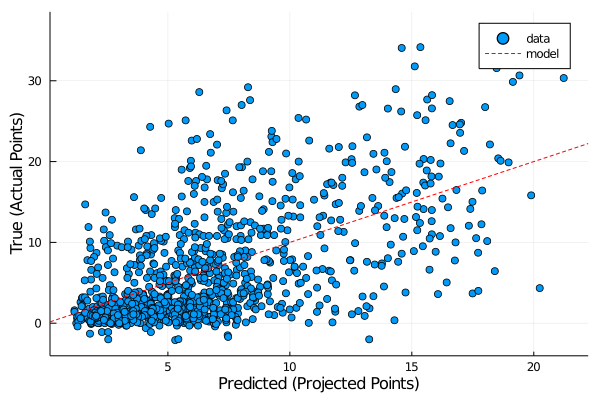

In [34]:
plot_pred_true(test_pred, test_std)

## OLS with GLM package
Use GLM package for OLS

In [35]:
Xtrain_glm = replace(hcat(convert(Matrix, train_real), train_cat_vals), NaN=>0)

41270×37 Array{Float64,2}:
   0.0    0.0      0.0        0.0     …  1785.39  1.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        1448.62  1.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        1634.88  0.0  1.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        1641.18  1.0  0.0  0.0  0.0  0.0
 251.75   1.25     0.5       31.5        1571.11  0.0  0.0  1.0  0.0  0.0
   0.0    0.0      0.0        0.0     …  1564.85  0.0  0.0  0.0  1.0  0.0
   0.0    0.0      0.0        0.0        1414.69  0.0  1.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        1566.56  1.0  0.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        1446.94  0.0  1.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        1606.97  0.0  0.0  0.0  1.0  0.0
   0.0    0.0      0.0        0.0     …  1516.61  0.0  0.0  0.0  1.0  0.0
   0.0    0.0      0.0        0.0        1468.45  0.0  1.0  0.0  0.0  0.0
   0.0    0.0      0.0        0.0        1404.48  1.0  0.0  0.0  0.0  0.0
   ⋮       

Use $\texttt{allowrankdeficient = true}$ to analytically solve some of the issues with multicollinearity.

In [36]:
m2 = lm(Xtrain, train_std, true)

LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,CholeskyPivoted{Float64,Array{Float64,2}}}}:

Coefficients:
───────────────────────────────────────────────────────────────────────────
            Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────
x1    0.0182532    0.00426003    4.28    <1e-4    0.00990348    0.026603
x2    1.04217      0.201338      5.18    <1e-6    0.647539      1.43679
x3   -0.241081     0.214041     -1.13    0.2600  -0.660607      0.178444
x4   -0.177808     0.0439282    -4.05    <1e-4   -0.263908     -0.0917075
x5    0.368854     0.0728322     5.06    <1e-6    0.226101      0.511606
x6    0.141952     0.0293627     4.83    <1e-5    0.0844004     0.199503
x7    0.0449677    0.00601889    7.47    <1e-13   0.0331705     0.0567648
x8    1.18961      0.239272      4.97    <1e-6    0.720635      1.65859
x9   -0.264466     0.0759945    -3.48    0.0005  -0.413416   

In [37]:
Xtest_glm = replace(hcat(convert(Matrix, test_real), test_cat_vals), NaN=>0)
pred_m2_test = predict(m2, Xtest)
test_MSE = MSE(test_std, pred_m2_test)

32.58896789315854

That allows us to calculate OLS with the typical algorithm.

In [39]:
m3 = lm(Xtrain, train_std);

In [40]:
pred_m3 = predict(m3, Xtrain);

In [41]:
# Xtest_glm2 = hcat(Xtest_glm[:,1:93], Xtest_glm[:, 95:128], Xtest_glm[:, 130:184])
pred_m3_test = predict(m3, Xtest)
test_MSE = MSE(test_std, pred_m3_test)

32.58896789315854

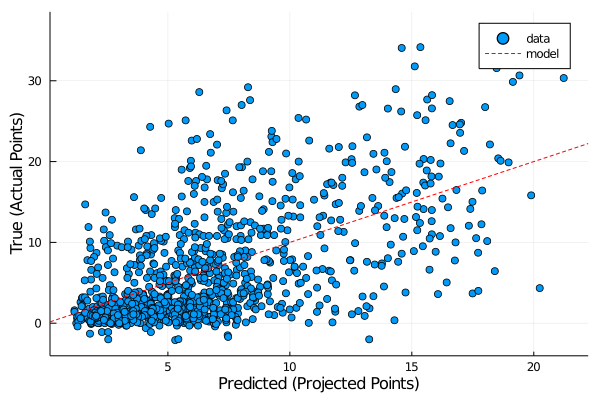

In [42]:
plot_pred_true(pred_m2_test, test_std)
# savefig("ols.png")

# Lasso Regression
## Lasso paths with Lasso.jl

In [43]:
m_lasso = fit(LassoPath, Xtrain, train_std, Normal())

LassoPath (81) solutions for 38 predictors in 6119 iterations):
───────────────────────────────────
               λ    pct_dev  ncoefs
───────────────────────────────────
 [1]  2.81918     0.0             0
 [2]  2.56873     0.0279611       1
 [3]  2.34053     0.0511748       1
 [4]  2.1326      0.0704473       1
 [5]  1.94315     0.0864477       1
 [6]  1.77053     0.100717        2
 [7]  1.61324     0.122905        2
 [8]  1.46992     0.14163         3
 [9]  1.33934     0.157215        3
[10]  1.22035     0.170154        3
[11]  1.11194     0.187589        4
[12]  1.01316     0.209624        7
[13]  0.923154    0.229394        8
[14]  0.841143    0.246236        8
[15]  0.766418    0.260217        8
[16]  0.698332    0.271823        8
[17]  0.636294    0.28146         8
[18]  0.579767    0.289463        8
[19]  0.528263    0.296105        9
[20]  0.481333    0.301728       10
[21]  0.438573    0.306426       10
[22]  0.399611    0.310326       10
[23]  0.364111    0.313565       11


In [44]:
pred_m_lasso_test = predict(m_lasso, Xtest)[:, 81]
test_MSE_lasso = MSE(test_std, pred_m_lasso_test)

32.57390613261489

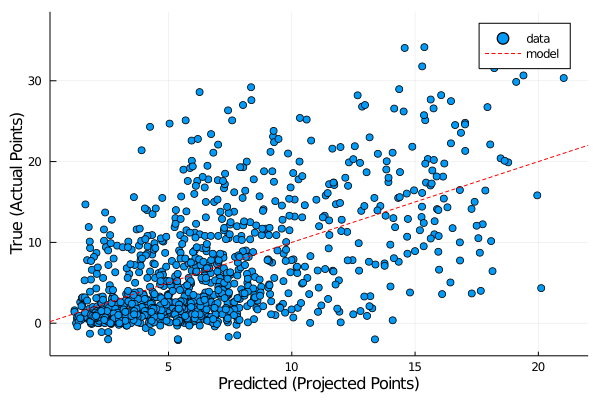

In [45]:
plot_pred_true(pred_m_lasso_test, test_std)
# savefig("lasso.png")

In [25]:
# plot(m_lasso; x = m_lasso[:, :logλ])

## Cross-validation procedure to select $\lambda$ for lasso regression

Train lasso model with 10-fold cross validation procedure.

In [82]:
# Xtrain = replace(hcat(convert(Matrix, train_real)), NaN=>0)
# Xtest = replace(hcat(convert(Matrix, test_real)), NaN=>0)

10550×30 Array{Float64,2}:
 224.286  1.0      0.571429  35.7143  …   1.0   -4.0  0.0  0.0  17.0  16.0
   0.0    0.0      0.0        0.0         6.0   34.0  0.0  0.0  13.0  27.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0  41.0  21.0
   0.0    0.0      0.0        0.0         8.0   20.0  0.0  0.0  10.0  40.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0   0.0   0.0
   0.0    0.0      0.0        0.0     …   5.0   37.0  0.0  0.0  27.0  37.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0   0.0   0.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0  54.0  51.0
 189.0    1.0      1.0       33.0         0.0    0.0  0.0  0.0  16.0  36.0
   0.0    0.0      0.0        0.0         2.0    2.0  0.0  0.0  10.0  34.0
   0.0    0.0      0.0        0.0     …   5.0   33.0  0.0  1.0  20.0  19.0
 215.333  1.66667  0.333333  31.6667      0.0    0.0  0.0  0.0  31.0  21.0
   0.0    0.0      0.0        0.0         0.0    0.0  0.0  0.0   0.0   0.

In [49]:
Random.seed!(0)
lasso_cv = fit(LassoModel, Xtrain, train_std; select = MinCVmse(Kfold(41270, 5)), standardize = false, intercept = false);

In [50]:
pred_lasso_cv = predict(lasso_cv, Xtest)

10319-element Array{Float64,1}:
 13.870535771160519
 13.825393076358685
  6.436185798526543
  9.017169701128473
  4.268609807856654
  7.201922242681618
  5.182967138491542
  4.657158950115322
  7.875611278383639
  4.286532507629207
  3.0109192109757608
  4.2643355887686045
 17.256184368428062
  ⋮
  7.041213233544676
 16.342512300776132
  6.813257407870825
  7.775775267190044
  8.874481754409931
  8.905278949120136
  7.8858971658188
  5.328111515129108
  4.6674558647384945
  7.725310743918794
  4.0516469998287095
  3.165934258816343

In [51]:
lasso_cv_ppr = fit(LassoModel, Xtrain, train_ppr; select = MinCVmse(Kfold(41270, 5)), standardize = false, intercept = false);
pred_lasso_cv_ppr = predict(lasso_cv_ppr, Xtest)
lasso_cv_half = fit(LassoModel, Xtrain, train_half; select = MinCVmse(Kfold(41270, 5)), standardize = false, intercept = false);
pred_lasso_cv_half = predict(lasso_cv_half, Xtest);

In [52]:
test_MSE_lasso_cv = MSE(test_std, pred_lasso_cv)
test_MSE_lasso_ppr = MSE(test_ppr, pred_lasso_cv_ppr)
test_MSE_lasso_half = MSE(test_half, pred_lasso_cv_half);

@show test_MSE_lasso_cv;
@show test_MSE_lasso_ppr;
@show test_MSE_lasso_half;

test_MSE_lasso_cv = 33.632945557691286
test_MSE_lasso_ppr = 46.486564050181634
test_MSE_lasso_half = 39.20968402486867


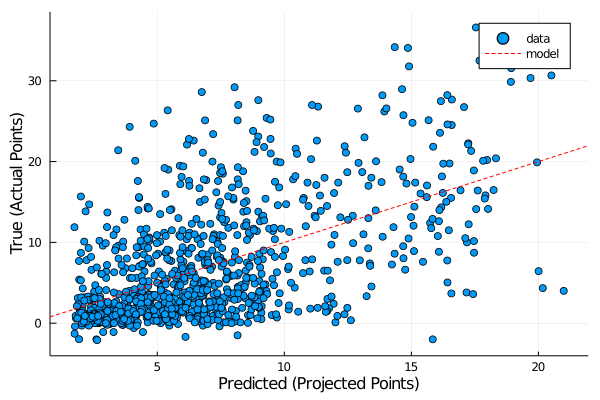

In [53]:
plot_pred_true(pred_lasso_cv, test_std)

Create dataframe of all data.

In [60]:
Xtrain_df = DataFrame(Xtrain)
Xtrain_df.Y = train_std
Xtrain_df;

## Export

Export linear predictions as a .csv for use in projections.

In [70]:
test_pred_all_impute = DataFrame(std_lasso = pred_lasso_cv, ppr_lasso = pred_lasso_cv_ppr, half_lasso = pred_lasso_cv_half)
# CSV.write("$(pwd())\\test_pred_impute.csv", test_pred_all_impute)

"C:\\Users\\darre\\Documents\\_cornell 20-21\\orie 4741\\dream-team\\base models\\test_pred_impute.csv"

In [66]:
df_x = df[:, Not([:StandardFantasyPoints, :PPRFantasyPoints, :HalfPPRFantasyPoints])]
df_real = df_x[:, labels_real]
df_cats = hcat([onehot(df_x[:, cat_labels[i]], cats_sets[i]) for i in 1:size(cat_labels, 1)]...)
df_matrix = replace(hcat(convert(Matrix, df_real), df_cats), NaN=>0)
# df_matrix = replace(convert(Matrix, df_real), NaN => 0)
points_pred_lm = predict(m2, df_matrix)
points_pred_lasso = predict(lasso_cv, df_matrix);

In [67]:
df_points = df[:, 1:4]
df_points.std_lm = points_pred_lm
df_points.std_lasso = points_pred_lasso
df_points.season = df[:, 24]
df_points

,week,Player,Pos,team1,std_lm,std_lasso,season
,Int64,String,String,String,Float64,Float64,Int64
1,15,Thomas Jones,RB,KAN,3.60148,4.05528,2011
2,4,Chris Ivory,RB,NYJ,10.8476,9.92826,2015
3,13,Pierre Garcon,WR,WAS,5.62815,6.18983,2012
4,5,Toby Gerhart,RB,MIN,2.53938,3.47873,2010
5,10,Brian Hoyer,QB,CLE,12.6734,14.0439,2014
6,9,Ben Watson,TE,CLE,5.50912,5.20937,2011
7,17,DeAndre Hopkins,WR,HOU,8.50684,6.9199,2016
8,17,Elijhaa Penny,RB,NYG,1.60779,2.62734,2018
9,12,Willie Snead,WR,NOR,7.19867,7.22473,2016


In [69]:
# CSV.write("..\\projections_2019\\points_proj_impute.csv", df_points)

"..\\projections_2019\\points_proj_impute.csv"